In [5]:
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm

In [6]:
tt = SMTT("numpy", "torch")

In [7]:
autoenc = models.SparseAutoEncoder(512, 1024).to("cuda")

loss_fn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(autoenc.parameters(), lr=1e-4, weight_decay=1e-3)

In [8]:
act_data = torch.load("all_games_act_data.pt")

In [9]:
tt(act_data)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2361456)
    |__dim_1 (512)


In [10]:
act_data[0].mean()

tensor(0.6646, device='cuda:0')

In [11]:
test = loss_fn(torch.zeros(2, 2), torch.ones(2, 2), reduction="none")
test

tensor([[1., 1.],
        [1., 1.]])

### Getting a sparser encoder! (actually following instructions)
- L0 around 10 or 20 on average across 1000 games
- feature density is mostly under 1%
- reconstruction loss stays low

In [12]:
epochs = 10
batch_size = 2**15
lam = 1e-7
losses = []
for epoch in range(epochs):
    for batch in range(0, act_data.shape[0], batch_size):
        dat = act_data[batch : batch + batch_size].to("cuda")

        l0, reg, guess = autoenc(dat)
        mse_loss = loss_fn(guess, dat)

        sparse_loss = lam * reg
        # sparse_loss = 0
        loss = mse_loss + sparse_loss
        # losses.append(interpretability.numpy(loss))
        losses.append([mse_loss.item(), sparse_loss.item(), l0.item()])
        optimizer.zero_grad()
        loss.backward()
        print(losses[-1])
        optimizer.step()

        with torch.no_grad():
            last_loss = loss_fn(guess, dat, reduction="none")

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
last_loss.sort()

torch.return_types.sort(
values=tensor([[5.3487e-09, 7.1918e-09, 3.5960e-08,  ..., 2.6246e-01, 2.6246e-01,
         2.8048e-01],
        [4.6919e-07, 6.7657e-07, 1.9079e-06,  ..., 1.0078e+00, 1.0573e+00,
         1.2321e+00],
        [8.9489e-07, 3.3453e-06, 1.2714e-05,  ..., 6.7506e-01, 7.4010e-01,
         1.2074e+00],
        ...,
        [2.1759e-07, 4.2643e-07, 5.7342e-06,  ..., 4.2370e-01, 4.3755e-01,
         6.2129e-01],
        [1.9072e-06, 2.4738e-06, 3.0429e-06,  ..., 5.2393e-01, 5.3203e-01,
         5.3374e-01],
        [1.9040e-10, 1.1574e-06, 1.2861e-06,  ..., 2.5548e-01, 2.7523e-01,
         3.1692e-01]], device='cuda:0'),
indices=tensor([[508, 314, 184,  ..., 393,   7, 168],
        [410, 507, 110,  ..., 285, 461, 308],
        [213, 335, 320,  ..., 135, 209, 368],
        ...,
        [191, 443, 265,  ..., 348, 406, 243],
        [265, 289, 176,  ...,  97, 158, 252],
        [ 40, 483, 242,  ..., 209, 153, 237]], device='cuda:0'))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

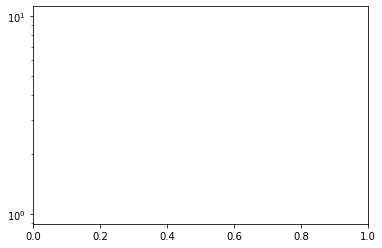

In [ ]:
plt.yscale("log")
plt.plot(range(len(losses)), losses)

Great. Now we've got an autoencoder, what do we do with it?

In [ ]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14].to("cuda")

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden
        total += tokens.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [ ]:
freqs = get_freqs(local_encoder=autoenc)

100%|██████████| 25/25 [00:23<00:00,  1.07it/s]

Num dead tensor(0.1621, device='cuda:0')


In [ ]:
tt(freqs)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (1024)


In [ ]:
print(freqs[112] * act_data.shape[0])

tensor(2202.3345, device='cuda:0')


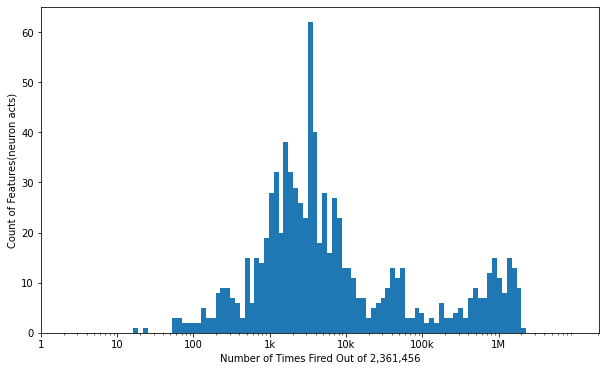

In [ ]:
x = interpretability.numpy(freqs) * act_data.shape[0]
# x = interpretability.numpy(freqs)
x = x[np.isfinite(x)]
fig, ax = plt.subplots()
# set figure size
fig.set_size_inches(10, 6)
ax.hist(x, bins=np.logspace(np.log10(5), np.log10(10000000), 100))
ax.set_xscale("log")
# x label
# ax.xlabel("Number of Moves (log 10 scale)");
# y label
# ax.ylabel("Count of Features(neuron acts)");
# set xtick and labels of ticks
tick_positions = [1, 10, 100, 1000, 10000, 100000, 1000000]
tick_labels = ["1", "10", "100", "1k", "10k", "100k", "1M"]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
# ax.get_xaxis().set_major_formatter(plt.ScalarFormatter());
ax.set_xlabel("Number of Times Fired Out of 2,361,456")
ax.set_ylabel("Count of Features(neuron acts)")

In [ ]:
torch.save(autoenc, "sparse_autoencoder_on_activations_02NOV2023.pt")